In [1]:
import pandas as pd
import os
import glob
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import ttest_ind
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
from combat import pycombat
from combat.pycombat import pycombat
import statsmodels.api as sm
from tqdm.notebook import tqdm
import statistics

combined_hc_data = pd.read_csv('/Users/martinli/Desktop/SZ/bayesian/combined_hc_data.csv', index_col=0)
combined_uc_data = pd.read_csv('/Users/martinli/Desktop/SZ/bayesian/combined_uc_data.csv', index_col=0)
combined_full_data = pd.concat([combined_hc_data, combined_uc_data], axis=1)

/var/folders/yv/682pv_nx7q561mgzzkj5sr280000gn/T/ipykernel_22169/291371336.py:22: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_hc_data = pd.read_csv('/Users/martinli/Desktop/SZ/bayesian/combined_hc_data.csv', index_col=0)
/var/folders/yv/682pv_nx7q561mgzzkj5sr280000gn/T/ipykernel_22169/291371336.py:23: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,

In [2]:
i2g = pd.read_csv('/Users/martinli/Desktop/SZ/bayesian/i2g_df_gene_ppion.csv', index_col=0)
i2g_ppion = i2g[i2g['ppion'] == True]
i2g_initial = i2g[i2g['initial'] == True]
gene_names = set(i2g_initial['gene_name'])
hc_columns = combined_hc_data.columns
uc_columns = combined_uc_data.columns

# 只筛选我们感兴趣的基因 （GNN）
filtered_hc_data = combined_hc_data.loc[combined_hc_data.index.isin(gene_names)]
filtered_uc_data = combined_uc_data.loc[combined_uc_data.index.isin(gene_names)]
combined_data = pd.concat([filtered_hc_data, filtered_uc_data], axis=1)
combined_data = combined_data.apply(pd.to_numeric, errors='coerce')
combined_data.dropna(axis=0, how='any', inplace=True)
print(combined_data.shape)
print(combined_data.head())

(16542, 320)
         GSM2932807  GSM2932808  GSM2932809  GSM2932810  GSM2932811  \
0                                                                     
A1BG         3.2298      7.3417    5.240800    2.555300    1.626500   
A1CF        11.3730     15.5388    6.019300   19.330600   12.206000   
A2ML1        0.1130      0.0100    0.043795    0.011602    0.011105   
A2M         83.9559    121.7395  138.736700   56.322100   33.125700   
A3GALT2      0.0100      0.0100    0.030966    0.039208    0.010000   

         GSM2932812  GSM2932813  GSM2932814  GSM2932815  GSM2932816  ...  \
0                                                                    ...   
A1BG       2.679200    2.790100     2.71550    2.230500     2.40190  ...   
A1CF      12.247100   12.537700    10.86450   15.144000    12.29160  ...   
A2ML1      0.088573    0.048154     0.03113    0.061851     0.16262  ...   
A2M       26.676100   44.366500    65.38850   36.885900    46.43040  ...   
A3GALT2    0.010000    0.010000  

In [3]:
# 批次列表
samples = combined_data.columns
# 根据样本名称进行分组，batch 1 对应 "GSM3316" 开头，batch 2 对应 "GSM2932" 开头
batch = [1 if col.startswith('GSM3316') else 2 for col in samples]

# 分离
batch1_data_before = combined_data.loc[:, [col for col, b in zip(combined_data.columns, batch) if b == 1]]
batch2_data_before = combined_data.loc[:, [col for col, b in zip(combined_data.columns, batch) if b == 2]]
#batch1_data = combined_full_data.loc[:, [col for col, b in zip(combined_data.columns, batch) if b == 1]]
#batch2_data = combined_full_data.loc[:, [col for col, b in zip(combined_data.columns, batch) if b == 2]]
print("Batch 1 data shape:", batch1_data_before.shape)
print("Batch 2 data shape:", batch2_data_before.shape)
plot_data = combined_data.T.copy()
plot_data['Batch'] = batch

Batch 1 data shape: (16542, 98)
Batch 2 data shape: (16542, 222)


In [4]:
# 应用 ComBat 批次效应batch
corrected_data = pycombat(combined_data, batch)
# 校正后数据形状
print("Corrected data shape:", corrected_data.shape)

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Corrected data shape: (16542, 320)


/Users/martinli/miniconda3/envs/bayesian/lib/python3.12/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


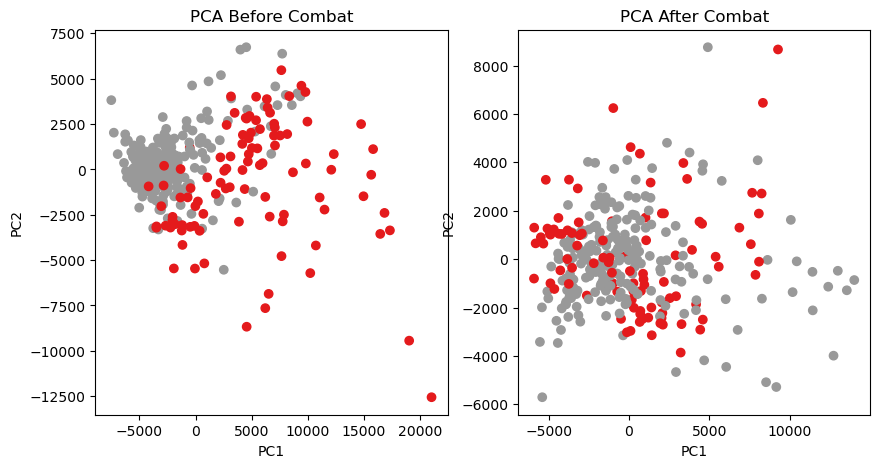

In [5]:
# 校正前的PCA
pca = PCA(n_components=2)
pca_before = pca.fit_transform(combined_data.T)  # 转置因为样本是列
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_before[:, 0], pca_before[:, 1], c=batch, cmap='Set1', label='Batch')
plt.title("PCA Before Combat")
plt.xlabel("PC1")
plt.ylabel("PC2")

# 校正后的PCA
pca_after = pca.fit_transform(corrected_data.T)  # 转置因为样本是列
plt.subplot(1, 2, 2)
plt.scatter(pca_after[:, 0], pca_after[:, 1], c=batch, cmap='Set1', label='Batch')
plt.title("PCA After Combat")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

In [6]:
# 检测残留的batch effect
# 校正前
X = sm.add_constant(batch)  # 添加常数项
model_before = sm.OLS(combined_data.mean(axis=0), X).fit()
print("Before Combat:")
print(model_before.summary())

# 校正后
model_after = sm.OLS(corrected_data.mean(axis=0), X).fit()
print("\nAfter Combat:")
print(model_after.summary())

Before Combat:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     181.9
Date:                Tue, 01 Oct 2024   Prob (F-statistic):           4.24e-33
Time:                        20:14:12   Log-Likelihood:                -846.50
No. Observations:                 320   AIC:                             1697.
Df Residuals:                     318   BIC:                             1705.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         37.1708      0.728     

In [7]:
# 计算校正前后的残差方差
residuals_before = combined_data.values - combined_data.mean(axis=1).values[:, np.newaxis]
residuals_after = corrected_data.values - corrected_data.mean(axis=1).values[:, np.newaxis]

variance_before = np.var(residuals_before)
variance_after = np.var(residuals_after)

print(f"Variance before Combat: {variance_before}")
print(f"Variance after Combat: {variance_after}")

Variance before Combat: 3180.6803010384624
Variance after Combat: 2158.1665026238093


In [8]:
gsm_to_group = {
    "GSM3316748": "HC", "GSM3316749": "HC", "GSM3316750": "HC", "GSM3316751": "HC", "GSM3316752": "HC",
    "GSM3316753": "HC", "GSM3316754": "HC", "GSM3316755": "HC", "GSM3316756": "HC", "GSM3316757": "HC",
    "GSM3316758": "HC", "GSM3316759": "HC", "GSM3316760": "HC", "GSM3316761": "HC", "GSM3316762": "HC",
    "GSM3316763": "HC", "GSM3316764": "HC", "GSM3316765": "HC", "GSM3316766": "HC", "GSM3316767": "HC",
    "GSM3316768": "HC", "GSM3316769": "HC", "GSM3316770": "HC", "GSM3316771": "HC", "GSM3316772": "HC",
    "GSM3316773": "HC", "GSM3316774": "HC", "GSM3316775": "HC", "GSM3316776": "HC", "GSM3316777": "HC",
    "GSM3316778": "HC", "GSM3316779": "HC", "GSM3316780": "HC", "GSM3316781": "HC", "GSM3316782": "HC",
    "GSM3316783": "HC", "GSM3316784": "HC", "GSM3316785": "HC", "GSM3316786": "HC", "GSM3316787": "HC",
    "GSM3316788": "HC", "GSM3316789": "HC", "GSM3316790": "HC", "GSM3316791": "HC", "GSM3316792": "HC",
    "GSM3316793": "HC", "GSM3316794": "HC", "GSM3316795": "HC", "GSM3316796": "HC", "GSM3316797": "HC",
    "GSM3316798": "HC", "GSM3316799": "HC", "GSM3316800": "HC", "GSM3316801": "HC", "GSM3316802": "HC",
    "GSM3316803": "UC", "GSM3316804": "UC", "GSM3316805": "UC", "GSM3316806": "UC", "GSM3316807": "UC",
    "GSM3316808": "UC", "GSM3316809": "UC", "GSM3316810": "UC", "GSM3316811": "UC", "GSM3316812": "UC",
    "GSM3316813": "UC", "GSM3316814": "UC", "GSM3316815": "UC", "GSM3316816": "UC", "GSM3316817": "UC",
    "GSM3316818": "UC", "GSM3316819": "UC", "GSM3316820": "UC", "GSM3316821": "UC", "GSM3316822": "UC",
    "GSM3316823": "UC", "GSM3316824": "UC", "GSM3316825": "UC", "GSM3316826": "UC", "GSM3316827": "UC",
    "GSM3316828": "UC", "GSM3316829": "UC", "GSM3316830": "UC", "GSM3316831": "UC", "GSM3316832": "UC",
    "GSM3316833": "UC", "GSM3316834": "UC", "GSM3316835": "UC", "GSM3316836": "UC", "GSM3316837": "UC",
    "GSM3316838": "UC", "GSM3316839": "UC", "GSM3316840": "UC", "GSM3316841": "UC", "GSM3316842": "UC",
    "GSM3316843": "UC", "GSM3316844": "UC", "GSM3316845": "UC",

    "GSM2932807": "HC", "GSM2932808": "HC", "GSM2932809": "HC", "GSM2932810": "HC", "GSM2932811": "HC",
    "GSM2932812": "HC", "GSM2932813": "HC", "GSM2932814": "HC", "GSM2932815": "HC", "GSM2932816": "HC",
    "GSM2932817": "HC", "GSM2932818": "HC", "GSM2932819": "HC", "GSM2932820": "HC", "GSM2932821": "HC",
    "GSM2932822": "HC", "GSM2932823": "HC", "GSM2932824": "HC", "GSM2932825": "HC", "GSM2932826": "HC",

    "GSM2932827": "UC", "GSM2932828": "UC", "GSM2932829": "UC", "GSM2932830": "UC", "GSM2932831": "UC",
    "GSM2932832": "UC", "GSM2932833": "UC", "GSM2932834": "UC", "GSM2932835": "UC", "GSM2932836": "UC",
    "GSM2932837": "UC", "GSM2932838": "UC", "GSM2932839": "UC", "GSM2932840": "UC", "GSM2932841": "UC",
    "GSM2932842": "UC", "GSM2932843": "UC", "GSM2932844": "UC", "GSM2932845": "UC", "GSM2932846": "UC",
    "GSM2932847": "UC", "GSM2932848": "UC", "GSM2932849": "UC", "GSM2932850": "UC", "GSM2932851": "UC",
    "GSM2932852": "UC", "GSM2932853": "UC", "GSM2932854": "UC", "GSM2932855": "UC", "GSM2932856": "UC",
    "GSM2932857": "UC", "GSM2932858": "UC", "GSM2932859": "UC", "GSM2932860": "UC", "GSM2932861": "UC",
    "GSM2932862": "UC", "GSM2932863": "UC", "GSM2932864": "UC", "GSM2932865": "UC", "GSM2932866": "UC",
    "GSM2932867": "UC", "GSM2932868": "UC", "GSM2932869": "UC", "GSM2932870": "UC", "GSM2932871": "UC",
    "GSM2932872": "UC", "GSM2932873": "UC", "GSM2932874": "UC", "GSM2932875": "UC", "GSM2932876": "UC",
    "GSM2932877": "UC", "GSM2932878": "UC", "GSM2932879": "UC", "GSM2932880": "UC", "GSM2932881": "UC",
    "GSM2932882": "UC", "GSM2932883": "UC", "GSM2932884": "UC", "GSM2932885": "UC", "GSM2932886": "UC",
    "GSM2932887": "UC", "GSM2932888": "UC", "GSM2932889": "UC", "GSM2932890": "UC", "GSM2932891": "UC",
    "GSM2932892": "UC", "GSM2932893": "UC", "GSM2932894": "UC", "GSM2932895": "UC", "GSM2932896": "UC",
    "GSM2932897": "UC", "GSM2932898": "UC", "GSM2932899": "UC", "GSM2932900": "UC", "GSM2932901": "UC",
    "GSM2932902": "UC", "GSM2932903": "UC", "GSM2932904": "UC", "GSM2932905": "UC", "GSM2932906": "UC",
    "GSM2932907": "UC", "GSM2932908": "UC", "GSM2932909": "UC", "GSM2932910": "UC", "GSM2932911": "UC",
    "GSM2932912": "UC", "GSM2932913": "UC", "GSM2932914": "UC", "GSM2932915": "UC", "GSM2932916": "UC",
    "GSM2932917": "UC", "GSM2932918": "UC", "GSM2932919": "UC", "GSM2932920": "UC", "GSM2932921": "UC",
    "GSM2932922": "UC", "GSM2932923": "UC", "GSM2932924": "UC", "GSM2932925": "UC", "GSM2932926": "UC",
    "GSM2932927": "UC", "GSM2932928": "UC", "GSM2932929": "UC", "GSM2932930": "UC", "GSM2932931": "UC",
    "GSM2932932": "UC", "GSM2932933": "UC", "GSM2932934": "UC", "GSM2932935": "UC", "GSM2932936": "UC",
    "GSM2932937": "UC", "GSM2932938": "UC", "GSM2932939": "UC", "GSM2932940": "UC", "GSM2932941": "UC",
    "GSM2932942": "UC", "GSM2932943": "UC", "GSM2932944": "UC", "GSM2932945": "UC", "GSM2932946": "UC",
    "GSM2932947": "UC", "GSM2932948": "UC", "GSM2932949": "UC", "GSM2932950": "UC", "GSM2932951": "UC",
    "GSM2932952": "UC", "GSM2932953": "UC", "GSM2932954": "UC", "GSM2932955": "UC", "GSM2932956": "UC",
    "GSM2932957": "UC", "GSM2932958": "UC", "GSM2932959": "UC", "GSM2932960": "UC", "GSM2932961": "UC",
    "GSM2932962": "UC", "GSM2932963": "UC", "GSM2932964": "UC", "GSM2932965": "UC", "GSM2932966": "UC",
    "GSM2932967": "UC", "GSM2932968": "UC", "GSM2932969": "UC", "GSM2932970": "UC", "GSM2932971": "UC",
    "GSM2932972": "UC", "GSM2932973": "UC", "GSM2932974": "UC", "GSM2932975": "UC", "GSM2932976": "UC",
    "GSM2932977": "UC", "GSM2932978": "UC", "GSM2932979": "UC", "GSM2932980": "UC", "GSM2932981": "UC",
    "GSM2932982": "UC", "GSM2932983": "UC", "GSM2932984": "UC", "GSM2932985": "UC", "GSM2932986": "UC",
    "GSM2932987": "UC", "GSM2932988": "UC", "GSM2932989": "UC", "GSM2932990": "UC", "GSM2932991": "UC",
    "GSM2932992": "UC", "GSM2932993": "UC", "GSM2932994": "UC", "GSM2932995": "UC", "GSM2932996": "UC",
    "GSM2932997": "UC", "GSM2932998": "UC", "GSM2932999": "UC", "GSM2933000": "UC", "GSM2933001": "UC",
    "GSM2933002": "UC", "GSM2933003": "UC", "GSM2933004": "UC", "GSM2933005": "UC", "GSM2933006": "UC",
    "GSM2933007": "UC", "GSM2933008": "UC", "GSM2933009": "UC", "GSM2933010": "UC", "GSM2933011": "UC",
    "GSM2933012": "UC", "GSM2933013": "UC", "GSM2933014": "UC", "GSM2933015": "UC", "GSM2933016": "UC",
    "GSM2933017": "UC", "GSM2933018": "UC", "GSM2933019": "UC", "GSM2933020": "UC", "GSM2933021": "UC",
    "GSM2933022": "UC", "GSM2933023": "UC", "GSM2933024": "UC", "GSM2933025": "UC", "GSM2933026": "UC",
    "GSM2933027": "UC", "GSM2933028": "UC", "GSM2933029": "UC", "GSM2933030": "UC", "GSM2933031": "UC",
    "GSM2933032": "UC"
}
# 基于样本映射将 UC 和 HC 样本分离
uc_samples = [col for col in corrected_data.columns if gsm_to_group.get(col) == "UC"]
hc_samples = [col for col in corrected_data.columns if gsm_to_group.get(col) == "HC"]

# 分离 UC 和 HC 数据
uc_data_corrected = corrected_data[uc_samples]
hc_data_corrected = corrected_data[hc_samples]

# 检查分离后的数据维度
print(f"UC data shape: {uc_data_corrected.shape}")
print(f"HC data shape: {hc_data_corrected.shape}")

UC data shape: (16542, 246)
HC data shape: (16542, 74)


In [9]:
# 加载基因映射文件
index_map = pd.read_csv('/Users/martinli/Desktop/SZ/bayesian/i2g_df_gene_ppion.csv')
print("Index map loaded.")

# 标准化基因名的函数
def standardize_gene_name(name):
    return name.strip().upper()

# 创建基因名到节点 ID 的映射
index_map['gene_name'] = index_map['gene_name'].fillna('').astype(str)
gene_to_node = {standardize_gene_name(gene): node for gene, node in zip(index_map['gene_name'], index_map['node'])}
print("Gene to node ID mapping created. Example mappings:", list(gene_to_node.items())[:5])

# 对 hc 和 uc 数据集中的基因名进行标准化
standardized_gene_names_hc = filtered_hc_data.index.map(lambda x: standardize_gene_name(str(x)))
standardized_gene_names_uc = filtered_uc_data.index.map(lambda x: standardize_gene_name(str(x)))

# 检查是否有基因未能映射到节点 ID
missing_genes_hc = standardized_gene_names_hc[~standardized_gene_names_hc.isin(gene_to_node)]
missing_genes_uc = standardized_gene_names_uc[~standardized_gene_names_uc.isin(gene_to_node)]
print(f"Number of HC genes missing from index map: {len(missing_genes_hc)}")
print(f"Number of UC genes missing from index map: {len(missing_genes_uc)}")
if not missing_genes_hc.empty:
    print("Example missing HC genes:", missing_genes_hc[:10])
if not missing_genes_uc.empty:
    print("Example missing UC genes:", missing_genes_uc[:10])

# 将基因名映射为节点 ID
mapped_node_ids_hc = standardized_gene_names_hc.map(gene_to_node.get)
mapped_node_ids_uc = standardized_gene_names_uc.map(gene_to_node.get)

# 检查是否有 NaN 映射
nan_hc = mapped_node_ids_hc[mapped_node_ids_hc.isna()]
nan_uc = mapped_node_ids_uc[mapped_node_ids_uc.isna()]

if not nan_hc.empty:
    print(f"HC dataset has NaN values for the following genes: {nan_hc}")
if not nan_uc.empty:
    print(f"UC dataset has NaN values for the following genes: {nan_uc}")

# 将 NaN 基因列移除，并将列名替换为节点 ID
hc_filtered = hc_data_corrected.loc[~mapped_node_ids_hc.isna(), :]
uc_filtered = uc_data_corrected.loc[~mapped_node_ids_uc.isna(), :]

hc_filtered.index = mapped_node_ids_hc.dropna()
uc_filtered.index = mapped_node_ids_uc.dropna()

print(f"Filtered HC dataset shape: {hc_filtered.shape}")
print(f"Filtered UC dataset shape: {uc_filtered.shape}")

# 导出标准化后的HC和UC数据
hc_filtered.to_csv('/Users/martinli/Desktop/SZ/bayesian/new_filtered_hc_data.csv')
uc_filtered.to_csv('/Users/martinli/Desktop/SZ/bayesian/new_filtered_uc_data.csv')
print("HC and UC datasets exported successfully.")

Index map loaded.
Gene to node ID mapping created. Example mappings: [('ARF5', 0.0), ('CALM2', 1.0), ('ARHGEF9', 2.0), ('ERN1', 3.0), ('CDKN2A', 4.0)]
Number of HC genes missing from index map: 0
Number of UC genes missing from index map: 0
Filtered HC dataset shape: (16542, 74)
Filtered UC dataset shape: (16542, 246)
HC and UC datasets exported successfully.


In [10]:
# 检查维度
print(uc_filtered.shape)  # 输出 (num_genes, num_uc_samples)
print(hc_filtered.shape)  # 输出 (num_genes, num_hc_samples)

(16542, 246)
(16542, 74)


In [11]:
from scipy.stats import mannwhitneyu
# 初始化结果字典
mannwhitney_results = {'Gene': [], 'U-statistic': [], 'p-value': []}

# 遍历每个基因进行Mann-Whitney U检验
for gene in uc_filtered.index:
    uc_values = uc_filtered.loc[gene, :]
    hc_values = hc_filtered.loc[gene, :]
    # 进行Mann-Whitney U检验
    U_stat, p_value = mannwhitneyu(uc_values, hc_values, alternative='two-sided')
    
    # 将结果存入字典
    mannwhitney_results['Gene'].append(gene)
    mannwhitney_results['U-statistic'].append(U_stat)
    mannwhitney_results['p-value'].append(p_value)

# 将结果转换为DataFrame
mannwhitney_df = pd.DataFrame(mannwhitney_results)

# 显示前几行结果
print(mannwhitney_df.head())
# 根据p-value筛选显著差异的基因，通常阈值为0.05
significant_genes = mannwhitney_df[mannwhitney_df['p-value'] < 0.01]
print("显著差异基因数:", len(significant_genes))

      Gene  U-statistic       p-value
0  10312.0      12522.0  9.571971e-07
1   2084.0       5192.0  2.113757e-08
2  12085.0      11010.0  6.263726e-03
3   1851.0      11230.0  2.297825e-03
4  16860.0       8839.0  6.969552e-01
显著差异基因数: 9766


In [12]:
# 使用 Benjamini-Hochberg 方法进行多重检验校正
from statsmodels.stats.multitest import multipletests

# 获取p值列表
p_values = mannwhitney_df['p-value']

# 进行Benjamini-Hochberg校正
rejected, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# 将校正后的p值添加到DataFrame中
mannwhitney_df['p-value_corrected'] = pvals_corrected

# 筛选显著差异的基因
significant_genes = mannwhitney_df[mannwhitney_df['p-value_corrected'] < 0.01]
print(f"显著差异的基因数量: {len(significant_genes)}")

# 显示前几行显著差异基因
print(significant_genes.head())

显著差异的基因数量: 9262
      Gene  U-statistic       p-value  p-value_corrected
0  10312.0      12522.0  9.571971e-07       3.148537e-06
1   2084.0       5192.0  2.113757e-08       8.997882e-08
3   1851.0      11230.0  2.297825e-03       4.405496e-03
5   4127.0      13400.0  7.346590e-10       3.925300e-09
8   3261.0       6899.5  1.602077e-03       3.162854e-03


In [13]:
significant_gene_list = significant_genes['Gene'].tolist()

# 筛选UC和HC数据，保留这些显著基因
uc_filtered = uc_filtered.loc[significant_gene_list, :]
hc_filtered = hc_filtered.loc[significant_gene_list, :]

# 查看筛选后的维度
print(f"筛选后的UC数据维度: {uc_filtered.shape}")
print(f"筛选后的HC数据维度: {hc_filtered.shape}")

corrected_data = pd.concat([hc_filtered, uc_filtered], axis=1)
corrected_data = corrected_data.apply(pd.to_numeric, errors='coerce')
corrected_data.dropna(axis=0, how='any', inplace=True)
corrected_data[corrected_data < 0] = 0
#维度
print(f"筛选后的数据维度: {corrected_data.shape}")

筛选后的UC数据维度: (9262, 246)
筛选后的HC数据维度: (9262, 74)
筛选后的数据维度: (9262, 320)


In [14]:
uc_filtered.to_csv('/Users/martinli/Desktop/SZ/bayesian/uc01.csv')
hc_filtered.to_csv('/Users/martinli/Desktop/SZ/bayesian/hc01.csv')

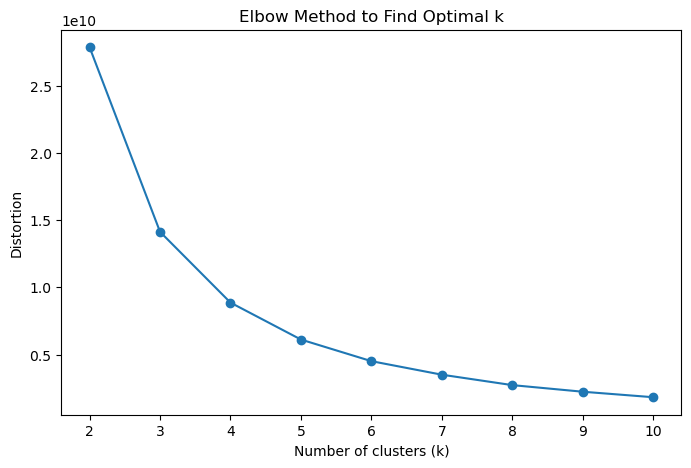

In [17]:
import matplotlib.pyplot as plt
import numpy as np
flattened_data = corrected_data.values.flatten().reshape(-1, 1)  # 将矩阵展平为一维向量

# 失真函数
def calculate_distortion(data, max_k=10):
    distortions = []
    K_range = range(2, max_k+1)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)  # 使用inertia_计算失真值
    return K_range, distortions

K_range, distortions = calculate_distortion(flattened_data)  # 转置以适应样本为行，基因为列

# 可视化失真函数
plt.figure(figsize=(8, 5))
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method to Find Optimal k')
plt.show()

In [ ]:
def calculate_bic_aic(data, max_k=10):
    bics = []
    aics = []
    K_range = range(1, max_k+1)
    for k in tqdm(K_range, desc="Calculating BIC and AIC for different k"):
        gmm = GaussianMixture(n_components=k, random_state=42, n_init=2, max_iter=50)
        gmm.fit(data)
        bics.append(gmm.bic(data))
        aics.append(gmm.aic(data))
    return K_range, bics, aics

K_range, bics, aics = calculate_bic_aic(flattened_data, max_k=10)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(K_range, bics, label='BIC', marker='o')
plt.plot(K_range, aics, label='AIC', marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Information Criterion')
plt.title('BIC and AIC to Find Optimal k')
plt.legend()
plt.show()

In [54]:
original_values = corrected_data.copy()  # 记录聚类前的原始值
flattened_data = corrected_data.values.flatten().reshape(-1, 1)
gmm = GaussianMixture(n_components=10, random_state=1999)
for _ in tqdm(range(1), desc="Performing global clustering"):
    gmm_clusters = gmm.fit_predict(flattened_data)  # 全局聚类
discretized_data = gmm_clusters.reshape(corrected_data.shape)
comparison_df = pd.DataFrame({
    'Original_Value': corrected_data.values.flatten(),
    'Clustered_Value': gmm_clusters
})
discretized_data = pd.DataFrame(discretized_data, index=corrected_data.index, columns=corrected_data.columns)

Performing global clustering:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/martinli/miniconda3/envs/bayesian/lib/python3.12/site-packages/sklearn/mixture/_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


In [55]:
grouped_stats = comparison_df.groupby('Clustered_Value')['Original_Value'].describe()
grouped_stats

,count,mean,std,min,25%,50%,75%,max
Clustered_Value,,,,,,,,
0,311243.0,0.009946,0.001320,0.004138,0.009644,0.009958,0.010123,0.015767
1,51149.0,316.379796,105.010880,187.513345,226.722953,288.009547,389.030514,569.832749
2,104.0,6833.449537,1177.707671,5674.307122,5971.794466,6480.586089,7431.951362,10794.118065
3,4306.0,1820.297519,267.678964,1468.008528,1589.754020,1756.564931,2010.984344,2448.944454
4,471746.0,35.814732,11.559692,21.129948,26.058298,32.915666,43.712292,64.238901
5,1886.0,3552.609219,789.636985,2450.036483,2867.965635,3428.869356,4118.188326,5670.676724
6,26870.0,905.237791,239.957679,569.853861,700.448155,858.681559,1083.165524,1467.937488
7,1020280.0,10.389563,4.816489,3.772296,6.213113,9.442833,14.028512,21.129897
8,907559.0,1.247868,1.117062,0.000000,0.244975,0.909214,2.103030,3.772274


In [58]:
# Add a column for the count of each cluster and calculate the min and max
intervals_with_count = comparison_df.groupby('Clustered_Value')['Original_Value'].agg([min, max, 'count'])

# Sort the intervals by the minimum value and print them out
sorted_intervals_with_count = intervals_with_count.sort_values(by='min')

# Display the sorted intervals with count for each cluster
print(sorted_intervals_with_count)

                         min           max    count
Clustered_Value                                    
8                   0.000000      3.772274   907559
0                   0.004138      0.015767   311243
7                   3.772296     21.129897  1020280
4                  21.129948     64.238901   471746
9                  64.239051    187.508828   168697
1                 187.513345    569.832749    51149
6                 569.853861   1467.937488    26870
3                1468.008528   2448.944454     4306
5                2450.036483   5670.676724     1886
2                5674.307122  10794.118065      104


/var/folders/yv/682pv_nx7q561mgzzkj5sr280000gn/T/ipykernel_15199/1934800810.py:2: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  intervals_with_count = comparison_df.groupby('Clustered_Value')['Original_Value'].agg([min, max, 'count'])
/var/folders/yv/682pv_nx7q561mgzzkj5sr280000gn/T/ipykernel_15199/1934800810.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  intervals_with_count = comparison_df.groupby('Clustered_Value')['Original_Value'].agg([min, max, 'count'])


In [59]:
# 根据新的顺序创建 Clustered_Value 的映射关系
new_cluster_mapping = {
    0: 0,
    8: 1,
    7: 2,
    4: 3,
    9: 4,
    1: 5,
    6: 6,
    3: 7,
    5: 8,
    2: 9
}

# 使用 map 函数更新 comparison_df 中的 Clustered_Value
comparison_df['Clustered_Value'] = comparison_df['Clustered_Value'].map(new_cluster_mapping)

# 打印更新后的 comparison_df 以验证更改
print(comparison_df）

   Original_Value  Clustered_Value
0        3.199998                1
1        7.829374                2
2        5.464079                2
3        2.440613                1
4        1.394926                1


In [63]:
# 确保 comparison_df 中的 Clustered_Value 已经正确更新
print("Updated Clustered_Value in comparison_df:")
print(comparison_df.head())

# 从 comparison_df 中提取新的 Clustered_Value 并 reshape 为与 corrected_data 相同的形状
new_discretized_data = comparison_df['Clustered_Value'].values.reshape(corrected_data.shape)

# 将 new_discretized_data 转换为 DataFrame 以便后续操作
new_discretized_df = pd.DataFrame(new_discretized_data, index=corrected_data.index, columns=corrected_data.columns)

# 验证更新后的 discretized_data
print("Updated new_discretized_df (first few rows):")
print(new_discretized_df.head())

Updated Clustered_Value in comparison_df:
   Original_Value  Clustered_Value
0        3.199998                1
1        7.829374                2
2        5.464079                2
3        2.440613                1
4        1.394926                1
Updated new_discretized_df (first few rows):
         GSM2932807  GSM2932808  GSM2932809  GSM2932810  GSM2932811  \
0                                                                     
10312.0           1           2           2           1           1   
2084.0            2           2           2           2           2   
1851.0            4           4           4           3           3   
4127.0            1           1           2           1           1   
3261.0            2           3           2           2           2   

         GSM2932812  GSM2932813  GSM2932814  GSM2932815  GSM2932816  ...  \
0                                                                    ...   
10312.0           1           1           1          

In [64]:
grouped_stats = comparison_df.groupby('Clustered_Value')['Original_Value'].describe()
grouped_stats

,count,mean,std,min,25%,50%,75%,max
Clustered_Value,,,,,,,,
0,311243.0,0.009946,0.001320,0.004138,0.009644,0.009958,0.010123,0.015767
1,907559.0,1.247868,1.117062,0.000000,0.244975,0.909214,2.103030,3.772274
2,1020280.0,10.389563,4.816489,3.772296,6.213113,9.442833,14.028512,21.129897
3,471746.0,35.814732,11.559692,21.129948,26.058298,32.915666,43.712292,64.238901
4,168697.0,103.531519,32.031671,64.239051,76.815718,95.019659,123.970412,187.508828
5,51149.0,316.379796,105.010880,187.513345,226.722953,288.009547,389.030514,569.832749
6,26870.0,905.237791,239.957679,569.853861,700.448155,858.681559,1083.165524,1467.937488
7,4306.0,1820.297519,267.678964,1468.008528,1589.754020,1756.564931,2010.984344,2448.944454
8,1886.0,3552.609219,789.636985,2450.036483,2867.965635,3428.869356,4118.188326,5670.676724


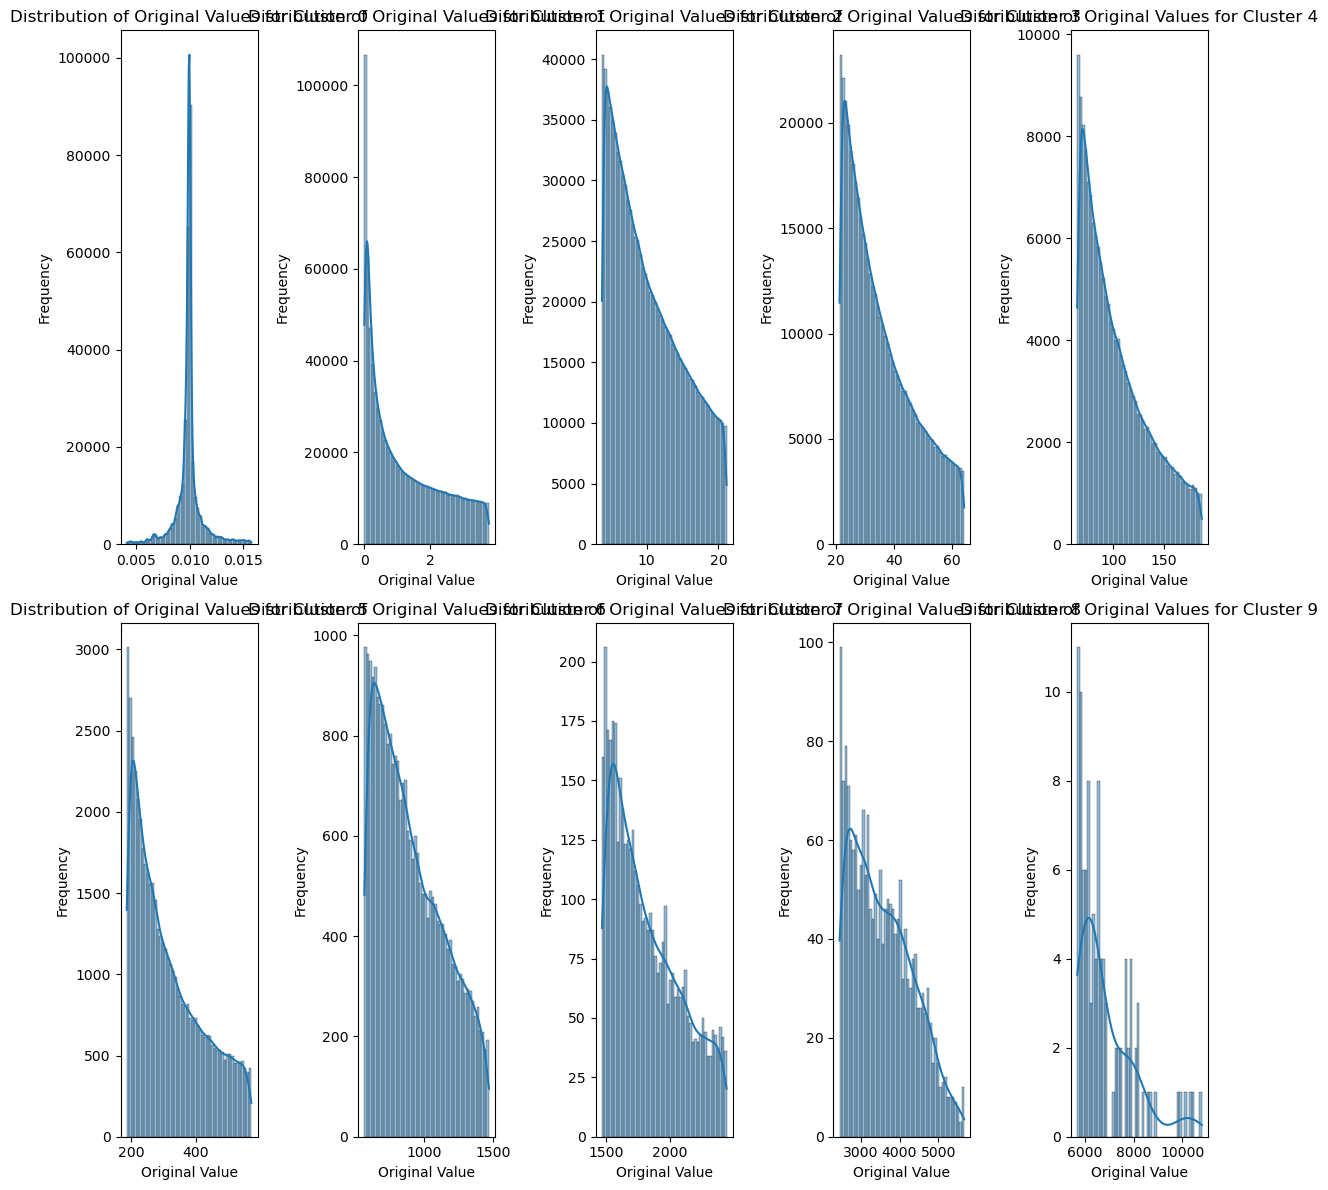

In [65]:
# Create a 2x2 grid of plots for the distribution of original values for each cluster
fig, axes = plt.subplots(2, 5, figsize=(12, 12))

# Flatten axes for easy indexing
axes = axes.flatten()

# Loop through each cluster and plot the distribution of original values in a 2x2 grid
for i, cluster in enumerate(grouped_stats.index):
    cluster_values = comparison_df[comparison_df['Clustered_Value'] == cluster]['Original_Value']
    
    # Plot the distribution for each cluster
    sns.histplot(cluster_values, kde=True, bins=50, ax=axes[i])
    
    # Set title and labels for each subplot
    axes[i].set_title(f'Distribution of Original Values for Cluster {cluster}')
    axes[i].set_xlabel('Original Value')
    axes[i].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [66]:
# 首先将 new_discretized_data 转换为 DataFrame
new_discretized_df = pd.DataFrame(new_discretized_data, index=corrected_data.index, columns=corrected_data.columns)

# 然后继续执行你的代码
hc = new_discretized_df.loc[:, new_discretized_df.columns.isin(hc_columns)]
uc = new_discretized_df.loc[:, new_discretized_df.columns.isin(uc_columns)]

batch1_hc_data = new_discretized_df.loc[:, new_discretized_df.columns.isin(hc_columns) & new_discretized_df.columns.str.startswith('GSM3')]
batch1_uc_data = new_discretized_df.loc[:, new_discretized_df.columns.isin(uc_columns) & new_discretized_df.columns.str.startswith('GSM3')]
batch2_hc_data = new_discretized_df.loc[:, new_discretized_df.columns.isin(hc_columns) & new_discretized_df.columns.str.startswith('GSM2')]
batch2_uc_data = new_discretized_df.loc[:, new_discretized_df.columns.isin(uc_columns) & new_discretized_df.columns.str.startswith('GSM2')]

print("Batch 1 / UC data shape:", batch1_uc_data.shape)
print("Batch 1 / HC data shape:", batch1_hc_data.shape)
print("Batch 2 / UC data shape:", batch2_uc_data.shape)
print("Batch 2 / HC data shape:", batch2_hc_data.shape)
print("UC data shape:", uc.shape)
print("HC data shape:", hc.shape)

Batch 1 / UC data shape: (9262, 43)
Batch 1 / HC data shape: (9262, 55)
Batch 2 / UC data shape: (9262, 203)
Batch 2 / HC data shape: (9262, 19)
UC data shape: (9262, 246)
HC data shape: (9262, 74)


<Figure size 1500x800 with 0 Axes>

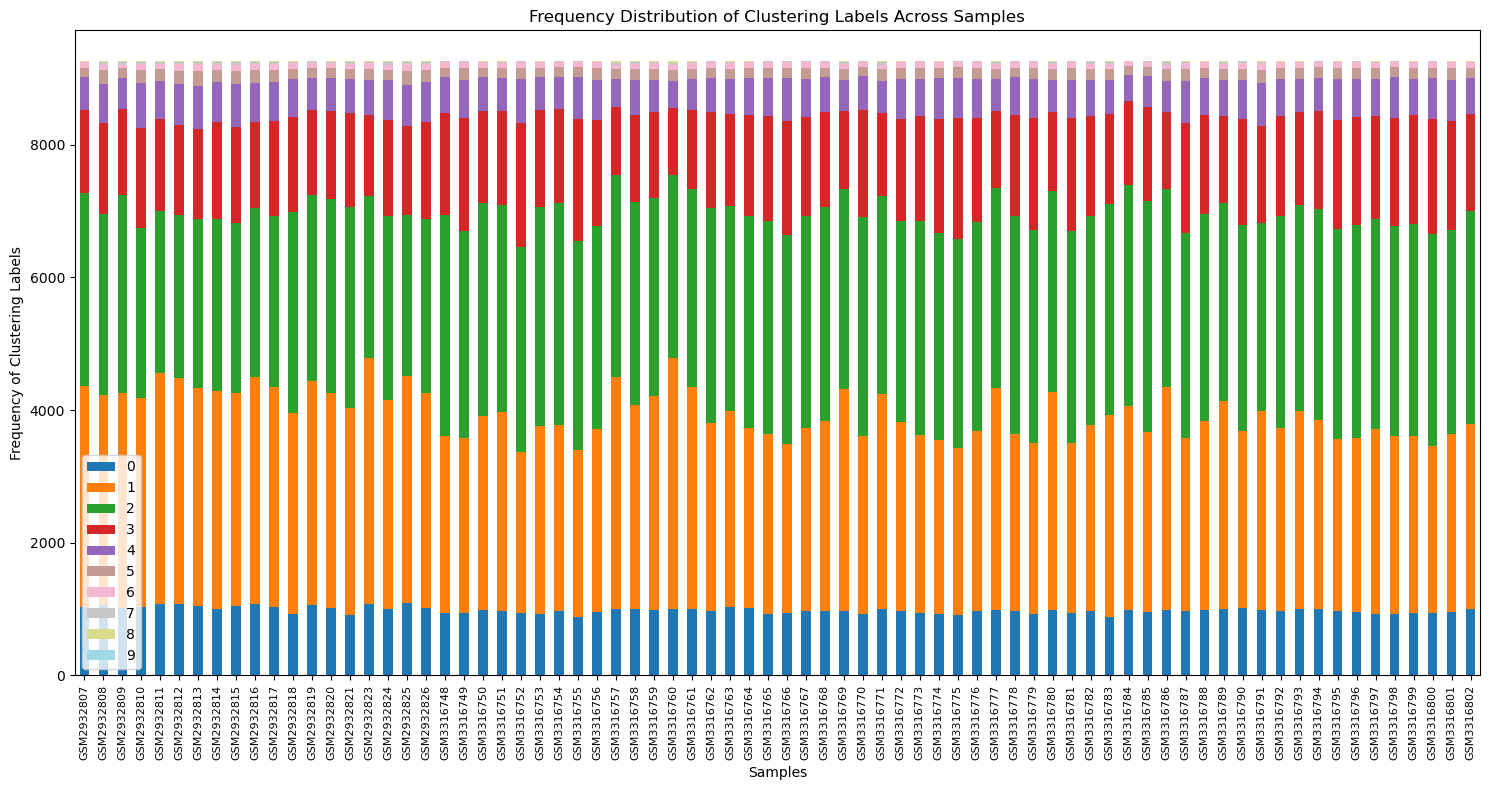

In [70]:
# 计算每个样本中不同聚类标签的频率分布
cluster_counts = hc.apply(pd.Series.value_counts).fillna(0)

# 绘制堆叠条形图，展示每个样本中不同聚类标签的分布情况
plt.figure(figsize=(15, 8))

# 转置数据以便堆叠条形图展示
cluster_counts.T.plot(kind='bar', stacked=True, colormap='tab20', figsize=(15, 8))

# 添加标题和标签
plt.title('Frequency Distribution of Clustering Labels Across Samples')
plt.xlabel('Samples')
plt.ylabel('Frequency of Clustering Labels')

plt.xticks(rotation=90, fontsize=8)  # 旋转样本标签，防止重叠
plt.tight_layout()

# 展示图形
plt.show()

<Figure size 1500x800 with 0 Axes>

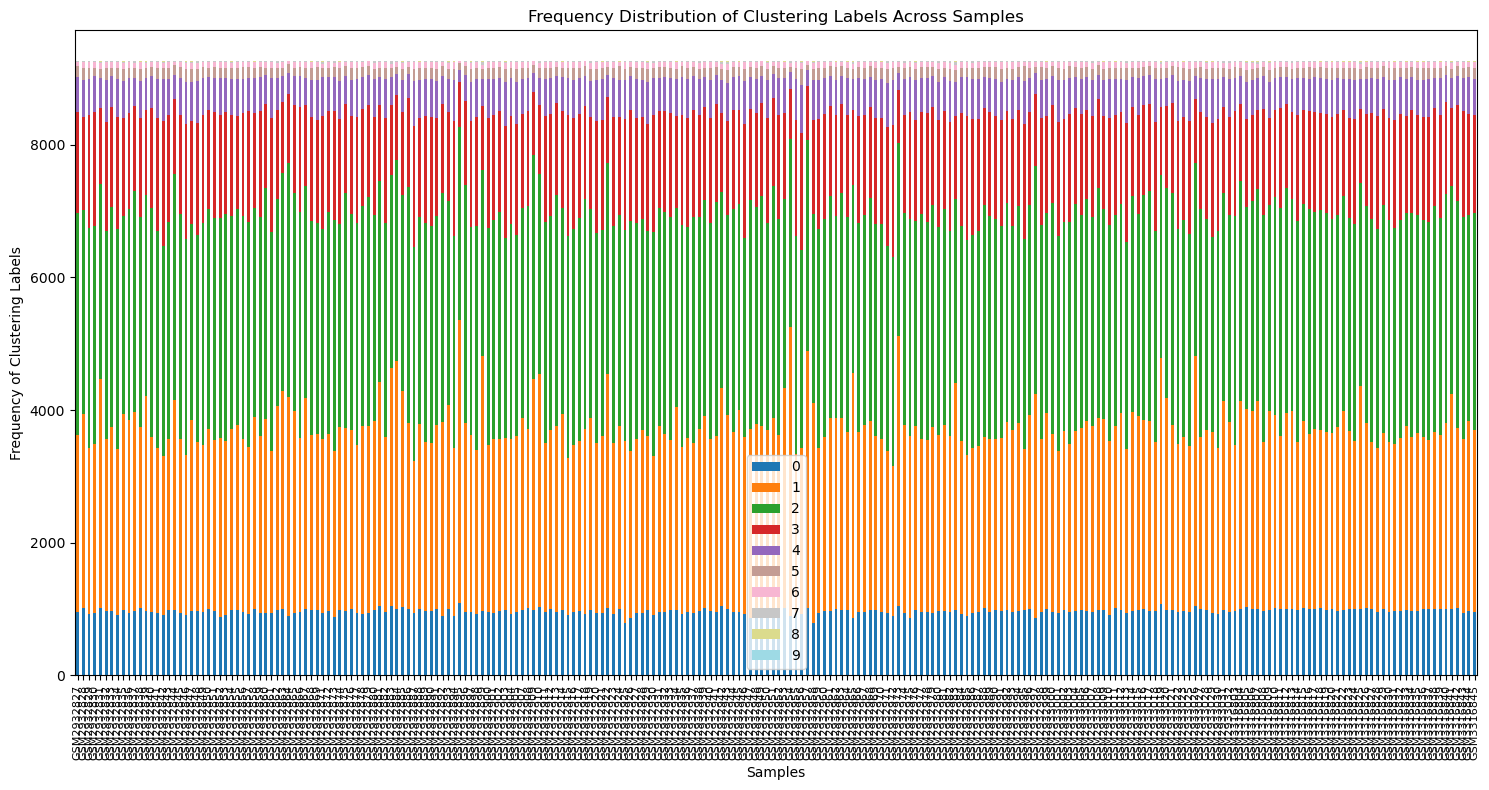

In [71]:
# 计算每个样本中不同聚类标签的频率分布
cluster_counts = uc.apply(pd.Series.value_counts).fillna(0)

# 绘制堆叠条形图，展示每个样本中不同聚类标签的分布情况
plt.figure(figsize=(15, 8))

# 转置数据以便堆叠条形图展示
cluster_counts.T.plot(kind='bar', stacked=True, colormap='tab20', figsize=(15, 8))

# 添加标题和标签
plt.title('Frequency Distribution of Clustering Labels Across Samples')
plt.xlabel('Samples')
plt.ylabel('Frequency of Clustering Labels')

plt.xticks(rotation=90, fontsize=8)  # 旋转样本标签，防止重叠
plt.tight_layout()

# 展示图形
plt.show()

In [42]:
from scipy.stats import mannwhitneyu

# 初始化 p 值列表
p_values = []

# 对每个基因进行 Mann-Whitney U 检验
for gene in corrected_data.index:
    hc_expr = batch1_hc_data.loc[gene].values
    uc_expr = batch1_uc_data.loc[gene].values
    
    # 检查数据是否为空
    if len(hc_expr) > 0 and len(uc_expr) > 0:
        stat, p_value = mannwhitneyu(hc_expr, uc_expr, alternative='two-sided')
        p_values.append(p_value)
    else:
        p_values.append(1)  # 如果没有足够的数据，设定 p 值为 1

# 多重检验校正
_, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# 生成结果的 DataFrame
diff_expr_df = pd.DataFrame({
    'Gene': corrected_data.index,
    'p_value': p_values,
    'corrected_p_value': corrected_p_values
})

# 筛选显著差异基因 (p < 0.05)
significant_genes = diff_expr_df[diff_expr_df['corrected_p_value'] < 0.2]

# 输出显著差异基因
print(significant_genes)

         Gene   p_value  corrected_p_value
1      2084.0  0.049791           0.138737
6      3704.0  0.000340           0.002271
7     16331.0  0.000058           0.000499
11     7998.0  0.000219           0.001546
12    14184.0  0.000039           0.000360
...       ...       ...                ...
9253  15973.0  0.000620           0.003753
9254  15780.0  0.004602           0.020010
9257   7801.0  0.064437           0.172891
9259  15088.0  0.023838           0.078155
9261    300.0  0.000068           0.000577

[3632 rows x 3 columns]


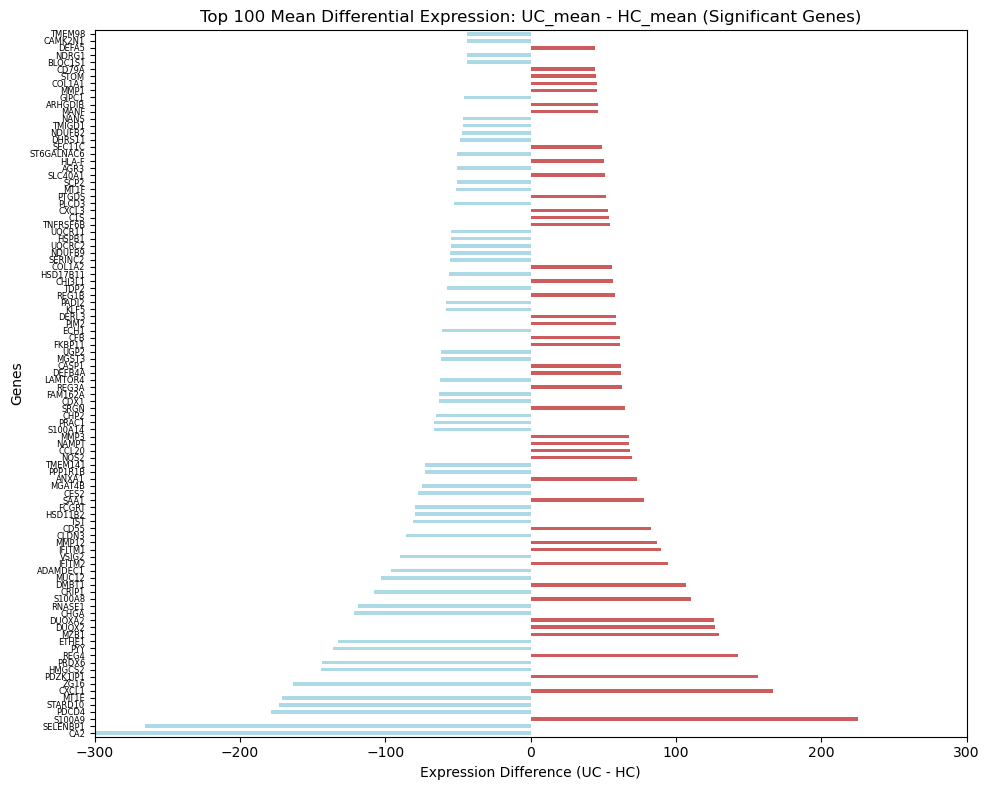

In [207]:
significant_gene_names = significant_genes['Gene'].tolist()
significant_data_hc = corrected_data.loc[significant_gene_names, hc_columns]
significant_data_uc = corrected_data.loc[significant_gene_names, uc_columns]

# 计算每个基因在 HC 和 UC 组的平均表达值
hc_mean = significant_data_hc.mean(axis=1)
uc_mean = significant_data_uc.mean(axis=1)

# 计算差值：UC 组 - HC 组
diff_expr = uc_mean - hc_mean

# 创建一个 DataFrame 来存储差值
diff_expr_df = pd.DataFrame({
    'Gene': significant_gene_names,
    'Expression Difference': diff_expr
}).set_index('Gene')

# 筛选出差异值的前 N 个基因（差异最大的）
top_n = 100
top_genes = diff_expr_df['Expression Difference'].abs().sort_values(ascending=False).head(top_n)
top_genes_with_sign = diff_expr_df.loc[top_genes.index, 'Expression Difference']
colors = ['indianred' if x > 0 else 'lightblue' for x in top_genes_with_sign]
plt.figure(figsize=(10, 8))
plt.xlim([-300, 300])
top_genes_with_sign.plot(kind='barh', color=colors)
plt.title(f'Top {top_n} Mean Differential Expression: UC_mean - HC_mean (Significant Genes)')
plt.xlabel('Expression Difference (UC - HC)')
plt.ylabel('Genes')
plt.yticks(fontsize=6)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.show()

In [217]:
# 加载基因映射文件
index_map = pd.read_csv('/Users/martinli/Desktop/SZ/bayesian/i2g_df_gene_ppion.csv')
print("Index map loaded.")
# 标准化基因名的函数
def standardize_gene_name(name):
    return name.strip().upper()
# 创建基因名到节点 ID 的映射
index_map['gene_name'] = index_map['gene_name'].fillna('').astype(str)
gene_to_node = {standardize_gene_name(gene): node for gene, node in zip(index_map['gene_name'], index_map['node'])}
print("Gene to node ID mapping created. Example mappings:", list(gene_to_node.items())[:5])
# 对 hc 和 uc 数据集中的基因名进行标准化
standardized_gene_names_hc = hc.index.map(lambda x: standardize_gene_name(str(x)))
standardized_gene_names_uc = uc.index.map(lambda x: standardize_gene_name(str(x)))
# 检查是否有基因未能映射到节点 ID
missing_genes_hc = standardized_gene_names_hc[~standardized_gene_names_hc.isin(gene_to_node)]
missing_genes_uc = standardized_gene_names_uc[~standardized_gene_names_uc.isin(gene_to_node)]
print(f"Number of HC genes missing from index map: {len(missing_genes_hc)}")
print(f"Number of UC genes missing from index map: {len(missing_genes_uc)}")
if not missing_genes_hc.empty:
    print("Example missing HC genes:", missing_genes_hc[:10])
if not missing_genes_uc.empty:
    print("Example missing UC genes:", missing_genes_uc[:10])
# 将基因名映射为节点 ID
mapped_node_ids_hc = standardized_gene_names_hc.map(gene_to_node.get)
mapped_node_ids_uc = standardized_gene_names_uc.map(gene_to_node.get)

# 检查是否有 NaN 映射
nan_hc = mapped_node_ids_hc[mapped_node_ids_hc.isna()]
nan_uc = mapped_node_ids_uc[mapped_node_ids_uc.isna()]

if not nan_hc.empty:
    print(f"HC dataset has NaN values for the following genes: {nan_hc}")
if not nan_uc.empty:
    print(f"UC dataset has NaN values for the following genes: {nan_uc}")

# 将 NaN 基因列移除，并将列名替换为节点 ID
hc_filtered = hc.loc[~mapped_node_ids_hc.isna(), :]
uc_filtered = uc.loc[~mapped_node_ids_uc.isna(), :]

hc_filtered.index = mapped_node_ids_hc.dropna()
uc_filtered.index = mapped_node_ids_uc.dropna()

print(f"Filtered HC dataset shape: {hc_filtered.shape}")
print(f"Filtered UC dataset shape: {uc_filtered.shape}")

Index map loaded.
Gene to node ID mapping created. Example mappings: [('ARF5', 0.0), ('CALM2', 1.0), ('ARHGEF9', 2.0), ('ERN1', 3.0), ('CDKN2A', 4.0)]
Number of HC genes missing from index map: 0
Number of UC genes missing from index map: 0
Filtered HC dataset shape: (16542, 74)
Filtered UC dataset shape: (16542, 246)


In [76]:
# 保存为 CSV 文件
hc.to_csv('/Users/martinli/Desktop/SZ/bayesian/new_hc.csv')
uc.to_csv('/Users/martinli/Desktop/SZ/bayesian/new_uc.csv')

print("HC and UC datasets have been saved as new_hc.csv and new_uc.csv.")

HC and UC datasets have been saved as new_hc.csv and new_uc.csv.
